In [ ]:
import boto3
import pandas as pd
import time

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='us-east-2'  # or your specific region
)

athena_client = session.client('athena')

# AWS Athena and S3 configuration
database = 'data'
table = '01'
output_location = 's3://lab4data-jfan16/queryresult/'
region_name = 'us-east-2'

query = f"SELECT * FROM \"{database}\".\"{table}\" LIMIT 10;"

# Start query execution
response = athena_client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': database},
    ResultConfiguration={'OutputLocation': output_location}
)

# Get query execution ID
query_execution_id = response['QueryExecutionId']

# Wait for the query to complete
while True:
    status = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    state = status['QueryExecution']['Status']['State']
    if state in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
        break
    time.sleep(2)

# Check if the query succeeded
if state == 'SUCCEEDED':
    # Get the result file from S3
    result_file = f"{output_location}{query_execution_id}.csv"
    # Load the result into a Pandas DataFrame
    df = pd.read_csv(result_file)
    print(df)
else:
    print(f"Query failed with state: {state}")


   timestep_time  vehicle_co  vehicle_co2  vehicle_hc  vehicle_nox  \
0            0.0         0.0      2416.04        0.01         0.72   
1            NaN         NaN          NaN         NaN          NaN   
2            1.0         0.0         0.00        0.00         0.00   
3            NaN         NaN          NaN         NaN          NaN   
4            2.0         0.0         0.00        0.00         0.00   
5            NaN         NaN          NaN         NaN          NaN   
6            3.0         0.0         0.00        0.00         0.00   
7            NaN         NaN          NaN         NaN          NaN   
8            4.0         0.0         0.00        0.00         0.00   
9            NaN         NaN          NaN         NaN          NaN   

   vehicle_pmx  vehicle_angle   vehicle_eclass  vehicle_electricity  \
0         0.01          42.25  HBEFA3/PC_G_EU4                  0.0   
1          NaN            NaN              NaN                  NaN   
2         0.00  

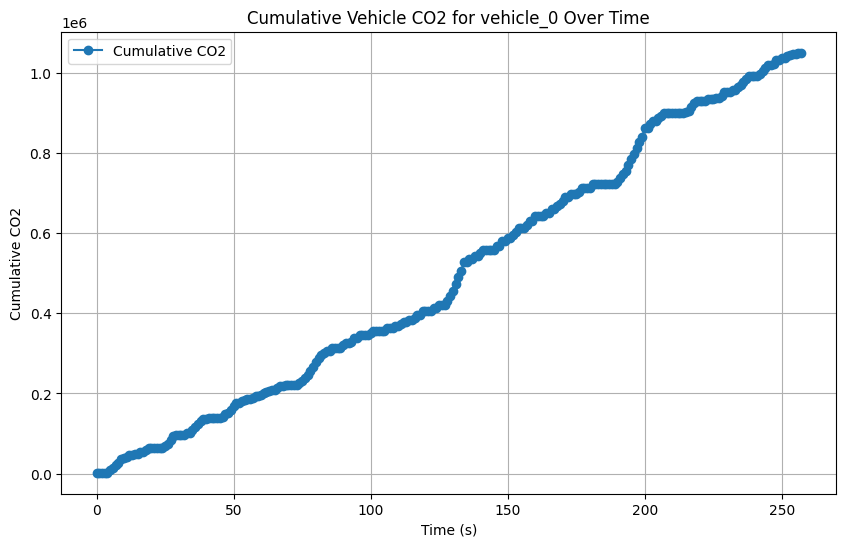

In [8]:
import matplotlib.pyplot as plt
# Modify the query to get all data related to vehicle_0
query = f"SELECT * FROM \"{database}\".\"{table}\" WHERE vehicle_id = 'veh0';"

# Start query execution
response = athena_client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': database},
    ResultConfiguration={'OutputLocation': output_location}
)

# Get query execution ID
query_execution_id = response['QueryExecutionId']

# Wait for the query to complete
while True:
    status = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    state = status['QueryExecution']['Status']['State']
    if state in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
        break
    time.sleep(2)

# Check if the query succeeded
if state == 'SUCCEEDED':
    # Get the result file from S3
    result_file = f"{output_location}{query_execution_id}.csv"
    # Load the result into a Pandas DataFrame
    df = pd.read_csv(result_file)
else:
    raise Exception(f"Query failed with state: {state}")
# Filter data for vehicle_0
vehicle_0_data = df[df['vehicle_id'] == 'veh0']

# Calculate cumulative CO2
vehicle_0_data['cumulative_co2'] = vehicle_0_data['vehicle_co2'].cumsum()

# Plot cumulative CO2 over time
plt.figure(figsize=(10, 6))
plt.plot(vehicle_0_data['timestep_time'], vehicle_0_data['cumulative_co2'], marker='o', label='Cumulative CO2')
plt.title('Cumulative Vehicle CO2 for vehicle_0 Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative CO2')
plt.legend()
plt.grid()
plt.show()

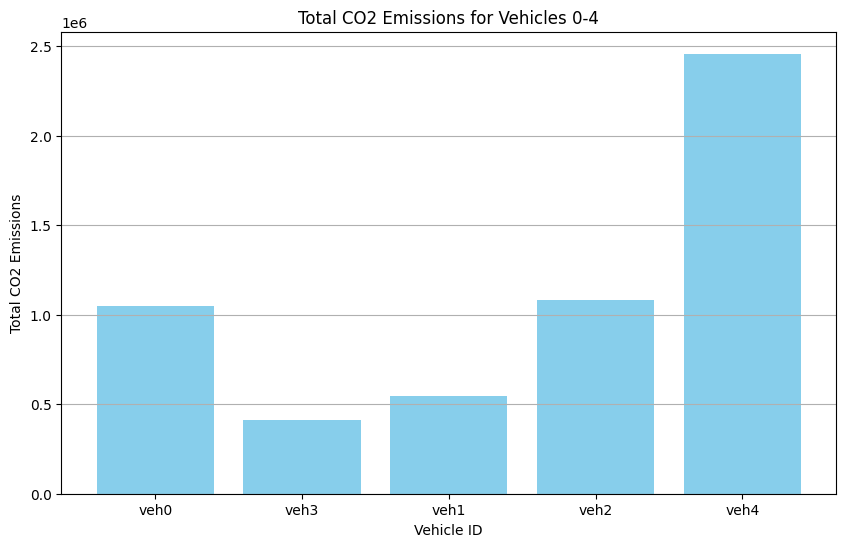

In [9]:
# Modify the query to get data for vehicles 0-4
query = f"""
SELECT vehicle_id, SUM(vehicle_co2) AS total_co2
FROM "{database}"."{table}"
WHERE vehicle_id IN ('veh0', 'veh1', 'veh2', 'veh3', 'veh4')
GROUP BY vehicle_id;
"""

# Start query execution
response = athena_client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': database},
    ResultConfiguration={'OutputLocation': output_location}
)

# Get query execution ID
query_execution_id = response['QueryExecutionId']

# Wait for the query to complete
while True:
    status = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    state = status['QueryExecution']['Status']['State']
    if state in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
        break
    time.sleep(2)

# Check if the query succeeded
if state == 'SUCCEEDED':
    # Get the result file from S3
    result_file = f"{output_location}{query_execution_id}.csv"
    # Load the result into a Pandas DataFrame
    emissions_df = pd.read_csv(result_file)
else:
    raise Exception(f"Query failed with state: {state}")

# Plot the total emissions as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(emissions_df['vehicle_id'], emissions_df['total_co2'], color='skyblue')
plt.title('Total CO2 Emissions for Vehicles 0-4')
plt.xlabel('Vehicle ID')
plt.ylabel('Total CO2 Emissions')
plt.grid(axis='y')
plt.show()